In [78]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma 
import networkx as nx

from sklearn.preprocessing import StandardScaler
from seaborn import palettes
from itertools import combinations
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed

from sklearn.svm import SVC

import sys
sys.path.append('/home/guest/Документы/medstats/Python_scripts')
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

In [89]:
X = pd.DataFrame(
    {
        'A': np.random.rand(1, 10).ravel(),
        'B': np.random.rand(1, 10).ravel(),
        'G': np.random.rand(1, 10).ravel()
        }
    )

Y_1 = np.random.randint(2, size=10)
Y_1

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1])

In [80]:
class DataFrameLoader(object):

    def __init__(
            self
        )-> None:
        pass     

    def fit(self, data: pd.core.frame.DataFrame):
        self.data = data
        self.nodes_lst = data.columns
        self.edges_lst = [i for i in list(combinations(self.nodes_lst, r = 2))]


class Prct(object):

    def __init__(self):
        pass


    def fit(self, data):

        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst

        model_lst = []

        for i in self.edges_lst: 

            _X = sma.add_constant(self.data[i[1]])
            _y = self.data[i[0]]
            model_ols = sma.OLS(_y, _X).fit()
            model_lst = model_lst + [model_ols]
        self._model_lst = model_lst

        _epsilons = np.array([])

        for i, model in zip(self.edges_lst, self._model_lst): 
            _epsilons = np.append(_epsilons, 
                np.array(model.predict(
                                sma.add_constant(self.data[i[1]])) - self.data[i[0]]), axis =0
            )
        self.epsilons = _epsilons.reshape(int(len(_epsilons)/len(self._model_lst)), len(self._model_lst))      


    def transform(self, newdata, newindex=None):      

        sc = StandardScaler()

        new_dfl = DataFrameLoader()
        self.newdata = newdata

        new_dfl.fit(self.newdata)
        
        self.new_nodes_lst = new_dfl.nodes_lst
        self.new_edges_lst = new_dfl.edges_lst

        assert self.new_nodes_lst.all() == self.nodes_lst.all(), f"Train data and new data have different features-nodes"
        assert self.new_edges_lst == self.edges_lst, f"Train data and new data have different features-edges"

        del self.new_nodes_lst
        del self.new_edges_lst

        _new_epsilons = np.array([])
        
        for i, model in zip(self.edges_lst, self._model_lst): 
            _new_epsilons = np.append(_new_epsilons, 
                np.array(model.predict(
                                sma.add_constant(self.newdata[i[1]])) - self.newdata[i[0]]), axis =0
            )
        self.new_epsilons = _new_epsilons.reshape(int(len(_new_epsilons)/len(self._model_lst)), len(self._model_lst))

        sc.fit(self.epsilons)
        self.new_epsilons = np.abs(sc.transform(self.new_epsilons))

        if newindex:
            self.index = newindex
        else:
            self.index = np.array(range(self.new_epsilons.shape[0]))
        

    def ntwrk_construct(self, type = 'thres'):

        self.graphs = dict()

        if type == 'weighted':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    print(edge, position, self.new_epsilons[index, position])
                    G.add_edge(edge[0], edge[1], weight = self.new_epsilons[index, position])

                self.graphs[index] = G

        elif type == 'thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1])

                self.graphs[index] = G

        elif type == 'weighted_thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1], weight = float(self.new_epsilons[index, position]))

                self.graphs[index] = G

        else:
            raise KeyboardError('Type must be `weighted`, `thres` or `weighted_thres`')

# +---------------------------------------------------------------------------------------------------------------------

class Snltc(object):

    def __init__(self):
        pass


    def fit(self, data, labels, clf=None):



        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst
        self.labels = labels

        model_lst = []

        for i in self.edges_lst: 
            if clf:
                pass
            else:
                clf = SVC(probability = True, random_state=0)

            model_lst = model_lst + [clf.fit(self.data[[i[0], i[1]]], self.labels)]
        self._model_lst = model_lst


    def transform(self, newdata, newindex=None):      

        new_dfl = DataFrameLoader()
        self.newdata = newdata

        new_dfl.fit(self.newdata)
        
        self.new_nodes_lst = new_dfl.nodes_lst
        self.new_edges_lst = new_dfl.edges_lst

        assert self.new_nodes_lst.all() == self.nodes_lst.all(), f"Train data and new data have different features-nodes"
        assert self.new_edges_lst == self.edges_lst, f"Train data and new data have different features-edges"

        del self.new_nodes_lst
        del self.new_edges_lst

        # _new_epsilons = np.zeros_like(self._model_lst)
        _new_epsilons = np.array([])
        
        for i, model in zip(self.edges_lst, self._model_lst): 
            # _new_epsilons = np.append(_new_epsilons, 
            #     np.array(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1]),axis=0)
            _new_epsilons = np.hstack([_new_epsilons, 
                np.array(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1])])
            # print(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1])
        
        self.new_epsilons = _new_epsilons.reshape(len(self._model_lst), int(len(_new_epsilons)/len(self._model_lst))).T

        if newindex:
            self.index = newindex
        else:
            self.index = np.array(range(self.new_epsilons.shape[0]))


    def ntwrk_construct(self, type = 'thres'):

        self.graphs = dict()

        if type == 'weighted':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    G.add_edge(edge[0], edge[1], weight = self.new_epsilons[index, position])

                self.graphs[index] = G

        elif type == 'thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1])

                self.graphs[index] = G

        elif type == 'weighted_thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1], weight = float(self.new_epsilons[index, position]))

                self.graphs[index] = G

        else:
            raise KeyboardError('Type must be `weighted`, `thres` or `weighted_thres`')


[1 1 1 1 0 0 1 0 1 0]


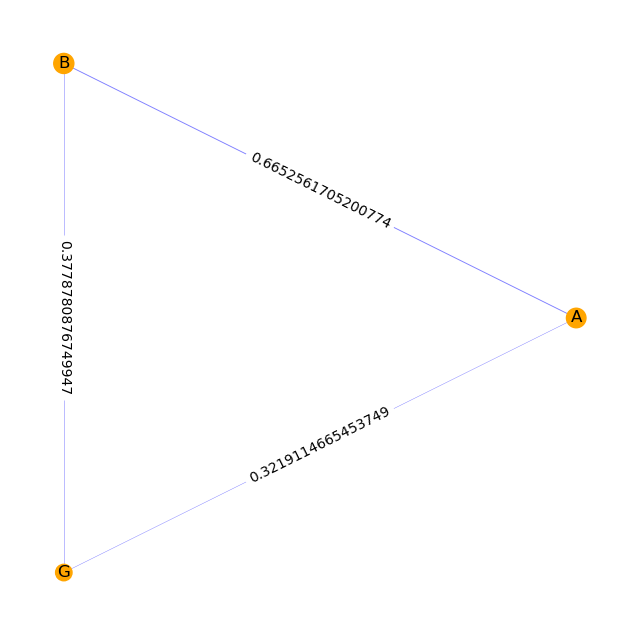

In [81]:
synolitic = Snltc()

synolitic.fit(X, Y_1)

synolitic.transform(X)

synolitic.ntwrk_construct(type='weighted')

print(Y_1)
graph_plotter(synolitic.graphs[2])

In [76]:
def graph_plotter(
    G, 
    figsize=(8,8), 
    title='',
    save = False
    ):
    
    pos = nx.circular_layout(G)   

    edge_labels = dict([((n1, n2), d['weight']) for 
        n1, n2, d in G.edges(data=True)])

    degree_dict = dict(G.degree(weight='weight'))

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.box(False)
    
    nx.draw_networkx_nodes(G, pos, node_color = 'orange', 
        node_size = [v * 200 for v in degree_dict.values()])
    nx.draw_networkx_labels(G, pos)

    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2],
        alpha=0.5, edge_color="b")

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5)

        
    if save:
        plt.savefig(title, bbox_inches="tight", transparent=False, 
            edgecolor = 'white', dpi = 300)
    
    else:
        plt.show()

## Correlation graphs...

In [84]:
class DataFrameLoader(object):

    def __init__(
            self
        )-> None:
        pass     

    def fit(self, data: pd.core.frame.DataFrame):
        self.data = data
        self.nodes_lst = data.columns
        self.edges_lst = [i for i in list(combinations(self.nodes_lst, r = 2))]


class Corr(object):

    def __init__(self):
        pass

    def fit(self, data, method = 'spearman', threshold = None):

        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst

        self.new_epsilons = np.array([])

        if method == 'pearson':

            for pair in self.edges_lst:
                weight, p_val = pearsonr(
                    self.data[pair[0]], 
                    self.data[pair[1]]
                    )
                if p_val < 0.05:
                    weight = np.abs(weight)
                else:
                    weight = 0

                self.new_epsilons = np.append(self.new_epsilons, weight)
            
        elif method == 'spearman':

            for pair in self.edges_lst:
                weight, p_val = spearmanr(
                    self.data[pair[0]], 
                    self.data[pair[1]]
                    )
                if p_val < 0.05:
                    weight = np.abs(weight)
                else:
                    weight = 0

                self.new_epsilons = np.append(self.new_epsilons, weight)

        else:
            raise KeyboardError('Method must be `pearson` or `spearman`')

        if threshold:
            np.place(self.new_epsilons, self.new_epsilons < threshold, 0) 


    def ntwrk_construct(self, newindex=None):

        if newindex:
            self.index = newindex
        else:
            raise ValueError('Provide `newindex`!')

        self.graphs = dict()  
          
        G = nx.Graph()
        G.add_nodes_from(self.nodes_lst)
        for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
            if float(self.new_epsilons[position]) != 0:
                G.add_edge(edge[0], edge[1], weight = self.new_epsilons[position])

        self.graphs[self.index] = G          

In [33]:
weight, p_val = pearsonr(X['A'], X['B'])
p_val

0.06022901959084606

[0.6969697 0.        0.       ]


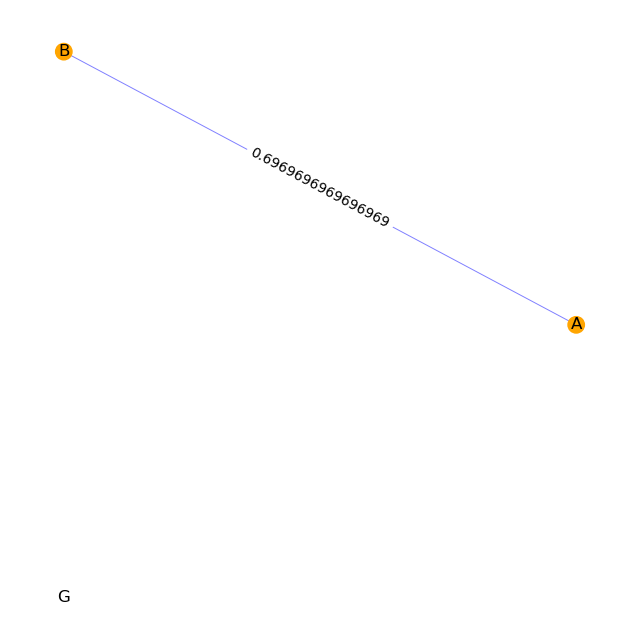

In [90]:
corrclass = Corr()

corrclass.fit(X)

corrclass.ntwrk_construct(9)
print(corrclass.new_epsilons)
graph_plotter(corrclass.graphs[9])